# Práctica Transfer Learning

En esta práctica vamos a ver cómo podemos añadir una capa a un modelo entrenado para resolver un problema específico. En este caso vamos a trabajar con un dataset con textos sobre Economía etiquetados como positivos o negativos. Podemos descargar el archivo en el siguiente [enlace](https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis?select=data.csv).


## Carga y preparación de los datos

Una vez descargado lo subimos a nuestra carpeta `data`:

In [1]:
!mkdir data

Comenzamos cargando los datos y viendo que se han cargado de manera correcta:

In [2]:
import numpy as np
import pandas as pd

In [3]:
datos = pd.read_csv('./data/data.csv')

In [4]:
datos.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


Eliminamos los comentarios neutrales y buscamos predecir solamente positivos o negativos.

In [5]:
datos_sin_neutral = datos[datos.Sentiment!="neutral"]

Transformo las etiquetas a un valor numérico para poder usarlas posteriormente en el entrenamiento de la red:

In [6]:
conversion_sentimientos = {'positive': 1, 'negative': 0}
datos_sin_neutral['Sentiment'] = datos_sin_neutral['Sentiment'].replace(conversion_sentimientos)
datos_sin_neutral.head()

<ipython-input-6-f1950021f6dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_sin_neutral['Sentiment'] = datos_sin_neutral['Sentiment'].replace(conversion_sentimientos)


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,1
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",0
2,"For the last quarter of 2010 , Componenta 's n...",1
5,$SPY wouldn't be surprised to see a green close,1
6,Shell's $70 Billion BG Deal Meets Shareholder ...,0


Separamamos como siempre en variables predictoras (`X`) y variable objetivo (`y`) así como en datos de entrenamiento (`train`) y validación (`test`):

In [7]:
X = datos_sin_neutral['Sentence']
y = datos_sin_neutral['Sentiment']
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)

Entrenamos un tokenizador sobre nuestros textos. Le damos un tamaño máximo al vocabulario de 10.000 palabras:

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
tamano_vocabulario = 10000
tokenizador = Tokenizer(num_words = tamano_vocabulario)
tokenizador.fit_on_texts(X_train)

Podemos ver cómo a cada palabra se le ha asociado un número, por ejemplo, a *aim*:

In [9]:
indice_palabras = tokenizador.word_index
indice_palabras["aim"]

742

__Nota.__ Puede salirte un número diferente porque cada vez que entrenas hay una componente aleatoria.

Convertimos cada frase en una secuencia de números usando esta traducción:

In [10]:
X_train_secuencias = tokenizador.texts_to_sequences(X_train)
X_test_secuencias = tokenizador.texts_to_sequences(X_test)

In [11]:
X_train_secuencias[5]

[218, 1, 872, 1178, 68, 761, 77, 762, 11, 1, 120]

Como hemos visto anteriormente para poder entrenar una red neuronal todas las frases tienen que tener el mismo tamaño por lo que vamos a fijar una longitud_maxima para cortar las frases que tengan una longitud mayor y rellenar las que tienen una menor:

In [12]:
longitud_maxima = 100

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(X_train_secuencias, maxlen=longitud_maxima, padding='post')
X_test_padded = pad_sequences(X_test_secuencias, maxlen=longitud_maxima, padding='post')


## Carga del modelo sobre el que se aplicará el Transfer Learning

Vamos a descargarnos un embedding ya preentrenado sobre el que añadiremos una nueva capa. Empezamos creando una carpeta donde almacenar el embedding:

In [14]:
!mkdir tmp

Importamos el embedding Glove, uno de los más conocidos. En el siguiente [enlace](https://nlp.stanford.edu/projects/glove/) puedes consultar la documentación del mismo.

In [15]:
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip -O ./tmp/embedding.zip

--2024-03-08 16:28:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-08 16:28:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-08 16:28:09--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘./tmp/embedding.zip

__Nota__ La descarga y descompresión del archivo puede llevar unos minutos.

Descomprimimos el archivo .zip:

In [16]:
import zipfile
with zipfile.ZipFile('./tmp/embedding.zip', 'r') as zip_ref:
    zip_ref.extractall('./tmp/glove')

Una vez descargado y descomprimido el embedding podemos proceder a cargarlo. Leeamos el archivo almacenando la información en un diccionario con clave cada palabra y valor un array con el vector del embedding asociado:

In [17]:
embeddings_index = {}
f = open('./tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split() # separamos cada línea por sus espacios
    word = values[0] # el primer elemento es la palabra
    coefs = np.asarray(values[1:], dtype='float32') # el resto de elementos forman el vector del embedding
    embeddings_index[word] = coefs # va rellenando el diccionario
f.close()

print('Se han cargado %s palabras con sus vectores.' % len(embeddings_index))

Se han cargado 400000 palabras con sus vectores.


Veamos un ejemplo:

In [18]:
embeddings_index['aim']

array([ 0.10113  , -0.39067  , -0.2382   ,  0.6699   ,  0.76998  ,
       -0.41243  , -0.23566  , -0.25177  ,  0.23691  ,  0.48351  ,
        0.03618  , -0.4098   ,  0.14127  , -0.37092  , -0.486    ,
       -0.31819  ,  0.11326  , -0.09891  , -0.86538  ,  0.041828 ,
       -0.0066207, -0.28286  , -0.051392 , -0.092905 , -0.39314  ,
        0.26564  , -0.18595  , -0.074037 , -0.041345 , -0.18247  ,
       -0.47814  ,  0.55718  ,  0.067117 , -0.1492   ,  0.13447  ,
       -0.53697  ,  0.40547  ,  0.020522 , -0.24831  ,  0.01222  ,
       -0.15321  ,  0.35971  ,  0.037537 , -0.026981 , -0.32134  ,
        0.092141 ,  0.29816  , -0.20756  , -0.99516  , -0.69498  ,
       -0.24596  ,  0.04189  , -0.30113  ,  1.1464   ,  0.14958  ,
       -1.8651   ,  0.19889  , -0.12974  ,  1.0141   , -0.13494  ,
       -0.17554  , -0.12646  , -0.38749  , -0.22537  ,  0.59453  ,
        0.32593  , -0.71206  ,  0.37951  ,  0.027276 , -0.81204  ,
        0.52119  , -0.48724  , -0.086435 , -0.68148  , -0.5353

Vamos a almacenar esta información en una matriz para poder utilizarla dentro de la red neuronal. La idea es crear una matriz de ceros y luego recorrer cada palabra de nuestro índice de palabras y comprobar si tiene embedding en Glove. Si lo tiene lo asociamos y si no la dejamos a cero:

In [19]:
embedding_matrix = np.zeros((len(indice_palabras) + 1, longitud_maxima)) # inicializo la matriz de ceros
for palabra, numero in indice_palabras.items(): # recorre el índice
    embedding_vector = embeddings_index.get(palabra) # extra el vector
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[numero] = embedding_vector #si el vector no es nulo lo añade en la posición de la matriz

In [20]:
indice_palabras["aim"]

742

In [27]:
embedding_matrix[742]

array([ 0.10113   , -0.39067   , -0.23819999,  0.6699    ,  0.76998001,
       -0.41242999, -0.23566   , -0.25176999,  0.23691   ,  0.48350999,
        0.03618   , -0.40979999,  0.14127   , -0.37092   , -0.486     ,
       -0.31819001,  0.11326   , -0.09891   , -0.86537999,  0.041828  ,
       -0.0066207 , -0.28286001, -0.051392  , -0.092905  , -0.39313999,
        0.26563999, -0.18595   , -0.074037  , -0.041345  , -0.18246999,
       -0.47814   ,  0.55717999,  0.067117  , -0.14920001,  0.13447   ,
       -0.53697002,  0.40547001,  0.020522  , -0.24831   ,  0.01222   ,
       -0.15321   ,  0.35971001,  0.037537  , -0.026981  , -0.32133999,
        0.092141  ,  0.29815999, -0.20756   , -0.99515998, -0.69498003,
       -0.24596   ,  0.04189   , -0.30113   ,  1.14639997,  0.14958   ,
       -1.86510003,  0.19889   , -0.12974   ,  1.01409996, -0.13494   ,
       -0.17554   , -0.12646   , -0.38749   , -0.22537   ,  0.59452999,
        0.32593   , -0.71205997,  0.37950999,  0.027276  , -0.81

Ya tenemos nuestra matriz lista para ser la primera capa de nuestra nueva red.

## Añadido de capas extra y entrenamiento del nuevo modelo

In [22]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

Comenzamos por la capa preentrenada:

In [23]:
embedding_layer = Embedding(len(indice_palabras) + 1,
                            longitud_maxima,
                            weights=[embedding_matrix],
                            input_length=longitud_maxima,
                            trainable=False) #marcamos la capa como no entrenable para no tener que volver a calcular estos parámetros

Construimos nuestro modelo:

In [24]:
red = Sequential([
    embedding_layer, # capa de embedding
    Bidirectional(LSTM(150, return_sequences=True)), #capa recurrente
    Bidirectional(LSTM(150)), #capa recurrente
    Dense(6, activation='relu'), #capa densa
   Dense(1, activation='sigmoid') #capa de salida como siempre con una neurona y activación sigmoidal
])

Estamos listos para entrenar nuestra red pero antes debemos indicarle qué optimizador debe usar (en este caso, Adam) que buscará reducir la pérdida de la red, qué función de pérdida (en este caso binary_crossentropy muy recomendada para clasificaciones binaria) y qué métrica vamos a monitorizar (en este caso la tasa de acierto):

In [25]:
red.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Entrenaremos durante 10 iteraciones para que el proceso no lleve demasiado tiempo. No dudes en probar números mayores y menores para observar sus consecuencias:

In [26]:
num_epochs = 10
history = red.fit(X_train_padded, y_train, epochs=num_epochs, validation_data=(X_test_padded, y_test))

Epoch 1/10
68/68 [==============================] - 61s 787ms/step - loss: 0.6042 - accuracy: 0.6846 - val_loss: 0.5300 - val_accuracy: 0.6759
Epoch 2/10
68/68 [==============================] - 50s 735ms/step - loss: 0.5129 - accuracy: 0.7326 - val_loss: 0.4867 - val_accuracy: 0.7477
Epoch 3/10
68/68 [==============================] - 50s 735ms/step - loss: 0.4529 - accuracy: 0.7732 - val_loss: 0.4513 - val_accuracy: 0.7661
Epoch 4/10
68/68 [==============================] - 50s 732ms/step - loss: 0.3991 - accuracy: 0.8331 - val_loss: 0.4619 - val_accuracy: 0.7919
Epoch 5/10
68/68 [==============================] - 53s 789ms/step - loss: 0.3438 - accuracy: 0.8548 - val_loss: 0.4783 - val_accuracy: 0.7808
Epoch 6/10
68/68 [==============================] - 51s 747ms/step - loss: 0.2933 - accuracy: 0.8746 - val_loss: 0.4693 - val_accuracy: 0.7882
Epoch 7/10
68/68 [==============================] - 52s 773ms/step - loss: 0.3258 - accuracy: 0.8663 - val_loss: 0.6083 - val_accuracy: 0.6740

Calculamos la tasa de acierto de nuestro modelo así como sus principales métricas y su matriz de confusión:

In [28]:
loss, accuracy = red.evaluate(X_test_padded,y_test)
print('Test accuracy :', accuracy)

17/17 [==============================] - 4s 208ms/step - loss: 0.6529 - accuracy: 0.7072
Test accuracy : 0.7071823477745056


In [29]:
predicciones = red.predict(X_test_padded)

17/17 [==============================] - 6s 255ms/step


In [32]:
predicciones[0:10]

array([[0.97682196],
       [0.96952194],
       [0.18735486],
       [0.3065185 ],
       [0.91333264],
       [0.98437303],
       [0.10023157],
       [0.05826048],
       [0.16388461],
       [0.8556005 ]], dtype=float32)

In [33]:
umbral = 0.5
y_pred_clase = (predicciones > umbral).astype(int)

In [34]:
y_pred_clase[0:10]

array([[1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1]])

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_test, y_pred_clase)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.72      0.62       177
           1       0.84      0.70      0.76       366

    accuracy                           0.71       543
   macro avg       0.69      0.71      0.69       543
weighted avg       0.74      0.71      0.72       543



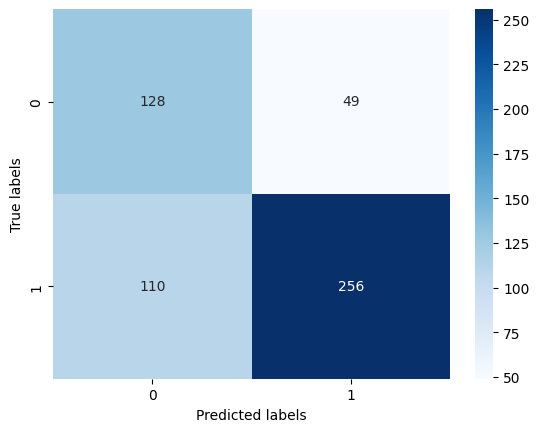

In [36]:
cm = confusion_matrix(y_test, y_pred_clase)
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizar la matriz de confusión
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Conclusión

Partiendo de una capa entrenada hemos sido capaces de añadir otras capas y convertir un embedding en un modelo de clasificación. Esta técnica abre un mundo de posibiliades para los usuarios permitiendo explotar los modelos entrenados y liberados por grandes entidades para su uso particular.

Como siempre te animo a probar nuevos parámetros y capas para intentar mejorar los resultados de la red.